# Lab 2b: Deep Learning Model (Part 2): Twitter Sentiment Analysis - Neural Network Modeling LSTM | Keras
by Group 8: Lu Han, Tony Chan, Michaela Hrabetova, Sangeeta Khanna, Cristina Endara# Lab 2b: Deep Learning Model (Part 1): Twitter Sentiment Analysis - Data cleaning and Data exploration
by Group 8: Lu Han, Tony Chan, Michaela Hrabetova, Sangeeta Khanna, Cristina Endara

In [ ]:
# Original Source

Work is based on "Twitter Sentiment Analysis" by Paolo Ripamonti on [kaggle.com](https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis)

There are heavy modifications to the original work for code enhancements, encapsulation, improvement, bug fixing in order to make the original source work for this project. Eventually, a realization of deep learning model within a python class called SentimentInferencing. Python source can be found in sentiment.py

Sample Notebook from https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis

# Twitter Sentiment Analysis

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/tony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Set up

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# FILE PATH
MYPATH = "../data/"

# EXPORT
KERAS_MODEL = MYPATH + "model.h5"
WORD2VEC_MODEL = MYPATH + "model.w2v"
TOKENIZER_MODEL = MYPATH + "tokenizer.pkl"
ENCODER_MODEL = MYPATH + "encoder.pkl"

In [4]:
# df = pd.read_csv('../input/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
df = pd.read_csv('../input/clean_tweet.csv')

In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [6]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 364 ms, sys: 5.72 ms, total: 369 ms
Wall time: 369 ms


In [7]:
# Text is cleaned in previous section
# stop_words = stopwords.words("english")
# stemmer = SnowballStemmer("english")

In [8]:
# def preprocess(text, stem=False):
#     # Remove link,user and special characters
#     text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
#     tokens = []
#     for token in text.split():
#         if token not in stop_words:
#             if stem:
#                 tokens.append(stemmer.stem(token))
#             else:
#                 tokens.append(token)
#     return " ".join(tokens)


In [7]:
df = df.dropna()

In [8]:
df_small = df.sample(200000)

In [10]:
# save a section for later use
# df_small.to_csv('../data/clean_tweet_small.csv',encoding='utf-8')

# Train Test Split

In [9]:
df_train, df_test = train_test_split(df_small, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 160000
TEST size: 40000


In [10]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 307 ms, sys: 19.6 ms, total: 327 ms
Wall time: 327 ms


# Word2Vec Model

In [13]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [14]:
w2v_model.build_vocab(documents)

2020-06-03 15:54:09,931 : INFO : collecting all words and their counts
2020-06-03 15:54:09,931 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-03 15:54:09,952 : INFO : PROGRESS: at sentence #10000, processed 117866 words, keeping 13090 word types
2020-06-03 15:54:09,973 : INFO : PROGRESS: at sentence #20000, processed 235751 words, keeping 19720 word types
2020-06-03 15:54:09,992 : INFO : PROGRESS: at sentence #30000, processed 354219 words, keeping 25186 word types
2020-06-03 15:54:10,013 : INFO : PROGRESS: at sentence #40000, processed 471867 words, keeping 29948 word types
2020-06-03 15:54:10,032 : INFO : PROGRESS: at sentence #50000, processed 589503 words, keeping 34181 word types
2020-06-03 15:54:10,052 : INFO : PROGRESS: at sentence #60000, processed 706889 words, keeping 37979 word types
2020-06-03 15:54:10,072 : INFO : PROGRESS: at sentence #70000, processed 824044 words, keeping 41632 word types
2020-06-03 15:54:10,094 : INFO : PROGRESS: at 

In [15]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 8560


In [16]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

d; awaiting finish of 6 more threads
2020-06-03 15:54:24,370 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-06-03 15:54:24,371 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-06-03 15:54:24,374 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-06-03 15:54:24,382 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-06-03 15:54:24,383 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-06-03 15:54:24,388 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-03 15:54:24,389 : INFO : EPOCH - 10 : training on 1878886 raw words (1378777 effective words) took 0.7s, 1897446 effective words/s
2020-06-03 15:54:25,053 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-06-03 15:54:25,057 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-06-03 15:54:25,058 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-

(44118917, 60124352)

In [17]:
w2v_model.most_similar("love")

2020-06-03 15:54:44,075 : INFO : precomputing L2-norms of word weight vectors


[('loooove', 0.49699947237968445),
 ('luv', 0.4920145869255066),
 ('adore', 0.4676995873451233),
 ('loves', 0.43705061078071594),
 ('loveee', 0.42477819323539734),
 ('loved', 0.424258828163147),
 ('appreciate', 0.42114749550819397),
 ('lov', 0.3446354269981384),
 ('admire', 0.3340601325035095),
 ('liked', 0.3301614820957184)]

# Tokenizing Text

In [18]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 67256
CPU times: user 1.95 s, sys: 11.7 ms, total: 1.96 s
Wall time: 1.96 s


In [19]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 2.59 s, sys: 49.4 ms, total: 2.64 s
Wall time: 2.65 s


In [20]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (160000, 1)
y_test (40000, 1)


In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (160000, 300)
y_train (160000, 1)

x_test (40000, 300)
y_test (40000, 1)


In [26]:
y_train[:10]


array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0]])

In [27]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(67256, 300)


In [28]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

# Building and Fitting Keras LSTM model

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          20176800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,337,301
Trainable params: 160,501
Non-trainable params: 20,176,800
_________________________________________________________________


In [30]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [31]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [32]:
%%time
EPOCHS = 2
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 144000 samples, validate on 16000 samples
Epoch 1/2
144000/144000 [==============================] - 233s 2ms/step - loss: 0.5591 - accuracy: 0.7095 - val_loss: 0.4849 - val_accuracy: 0.7758
Epoch 2/2
144000/144000 [==============================] - 230s 2ms/step - loss: 0.5070 - accuracy: 0.7537 - val_loss: 0.4651 - val_accuracy: 0.7843
CPU times: user 30min 48s, sys: 4min 27s, total: 35min 16s
Wall time: 7min 43s


# LSTM model accuracy

In [33]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40000/40000 [==============================] - 21s 518us/step

ACCURACY: 0.7781000137329102
LOSS: 0.4706464828491211
CPU times: user 1min 22s, sys: 5.98 s, total: 1min 28s
Wall time: 20.7 s


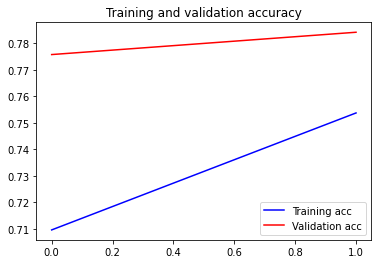

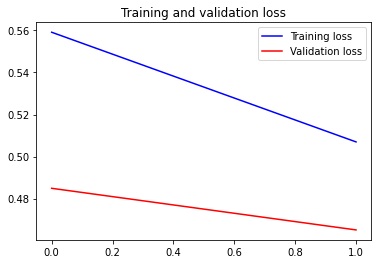

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [37]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

# Make Prediction

In [38]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [39]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9828066825866699,
 'elapsed_time': 0.12557506561279297}

In [40]:
predict("I hate the rain")


{'label': 'NEGATIVE',
 'score': 0.020826494321227074,
 'elapsed_time': 0.017711877822875977}

In [41]:
predict("i don't know what i'm doing")


{'label': 'NEUTRAL',
 'score': 0.6908887028694153,
 'elapsed_time': 0.02029705047607422}

# Saving Model Objects

In [43]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2020-06-03 16:20:22,705 : INFO : saving Word2Vec object under ../data/model.w2v, separately None
2020-06-03 16:20:22,705 : INFO : not storing attribute vectors_norm
2020-06-03 16:20:22,706 : INFO : not storing attribute cum_table
2020-06-03 16:20:22,814 : INFO : saved ../data/model.w2v
